In [1]:
import math
from PIL import Image
import PIL.ImageOps
import numpy as np

def coordinates_to_address(x, y):
    if x == 0 and y == 0:
        return 0

    layer = max(abs(x), abs(y))

    addr = (2 * layer - 1) ** 2 - 1

    if y == -layer:
        addr += 7 * layer + x
    elif x == -layer:
        addr += 5 * layer - y
    elif y == layer:
        addr += 3 * layer - x
    elif x == layer:
        addr += layer + y

    return addr

def get_bit(program, idx):
  byte_idx = idx >> 3
  bit_idx = idx & 7
  if byte_idx >= len(program):
    return 0
  return (program[byte_idx] >> bit_idx) & 1

def get_program_image(program):
  size = int(math.isqrt(len(program) * 8))
  bitmap = np.full((size, size), 0, dtype=np.uint8)
  for x in range(size):
    for y in range(size):
      addr = coordinates_to_address(x - size // 2, y - size // 2)
      res = get_bit(program, addr)
      bitmap[x, y] = (-res) & 0xFF
  img = Image.fromarray(bitmap, 'L').convert('1')
  return PIL.ImageOps.invert(img.resize((256,256)))


In [ ]:
import urllib.request
import struct
from IPython.display import Image as PythonImage


def get_animation(circo_url, circuit, program, frames=0x100):
    size = len(program)
    try:
        with open(circuit, "rb" ) as file:
            prog = file.read()
            prog += struct.pack("<H", size)
            prog += program

        want = size * frames

        req = urllib.request.Request(circo_url, data=prog, headers={"Range": "bytes=0-" + str(want)}, method='POST')
        with urllib.request.urlopen(req) as response:
            data = response.read()

        gif = get_program_image(data[0:len(program)]).convert("RGB")
        imgs = []
        pos = size
        for _ in range(frames):
            imgs.append(get_program_image(data[pos:(pos + len(program))]).convert("RGB"))
            pos += size

        gif.save("output.gif", save_all=True, append_images=imgs, duration=50, loop=0)
        return PythonImage("output.gif")
    except Exception as e:
        print("An error has occurred.")
        print(e)

In [ ]:
# PARAMS

circo_url = "http://circo.2025.ctfcompetition.com:1337/circo.circo"
# circo_url = "http://127.0.0.1:49185/circo.circo"
program = b"\x10\x00\x00\x10\xaa\xaa\xaa\xFF"
program += (b"\x00"*(256-len(program)))

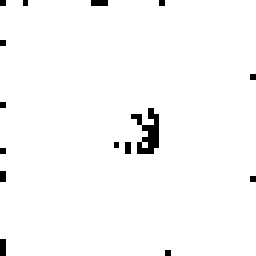

In [ ]:
get_animation(circo_url, "circo-sdk/signed_gol.prg", program)

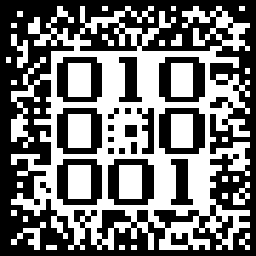

In [ ]:
get_animation(circo_url, "circo-sdk/signed_counter.prg", program)